### Housekeeping

In [134]:
import pandas as pd
import random
import numpy as np
import librosa
import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = "D:\\Datasets\\mozilla\\"
CLIPS_PATH = "D:\\Datasets\\mozilla\\clips\\"
TRAIN_DATA = "validated.tsv"

### EDA

In [3]:
df = pd.read_csv(DATA_PATH + TRAIN_DATA, sep='\t')

In [4]:
df.head()

,client_id,path,sentence,up_votes,down_votes,age,gender,accent
0,235bfe76c2f0aa72f8f217c70ade4fd10d7b8aa2f9707a...,common_voice_pt_19484624.mp3,Pedir dinheiro emprestado às pessoas da aldeia,2,1,NaN,NaN,NaN
1,25b96b97ba7e13e1cdb7696ddb8d0a214f7deb52839025...,common_voice_pt_19405032.mp3,Trancá-los,2,0,NaN,NaN,NaN
2,30291b4b87476b9d6503d7ae8cffa126a5143541de66c9...,common_voice_pt_19522569.mp3,O Youtube ainda é a melhor plataforma de vídeos.,2,0,NaN,NaN,NaN
3,31849d479fec44f97d7fc323ba25e29bc043acbd371514...,common_voice_pt_19665686.mp3,Menina e menino beijando nas sombras,2,0,NaN,NaN,NaN
4,32de5e96080644cc94bc1b86d8eec8fc23297f8d7432ed...,common_voice_pt_20183194.mp3,"Particularmente, meu cuscuz cortado eu gosto d...",2,0,NaN,NaN,NaN


In [5]:
df.describe()

,up_votes,down_votes,accent
count,22131.000000,22131.000000,0.0
mean,2.002576,0.057521,NaN
std,0.050686,0.233616,NaN
min,2.000000,0.000000,NaN
25%,2.000000,0.000000,NaN
50%,2.000000,0.000000,NaN
75%,2.000000,0.000000,NaN
max,3.000000,2.000000,NaN


In [6]:
len(df)

22131

In [7]:
df.isna().sum()

client_id         0
path              0
sentence          0
up_votes          0
down_votes        0
age            1816
gender         1816
accent        22131
dtype: int64

In [8]:
# mozilla site says 354 voices, assuming 319 validated
df.nunique()

client_id       319
path          22131
sentence      13355
up_votes          2
down_votes        3
age               7
gender            3
accent            0
dtype: int64

In [9]:
len(df[df.down_votes == 0]) / len(df)

0.9426596177307849

### Pairing Data

In [10]:
data = df[df.down_votes == 0]
data.nunique()

client_id       316
path          20862
sentence      13018
up_votes          2
down_votes        1
age               7
gender            3
accent            0
dtype: int64

In [11]:
voices_sorted = data.sort_values(by=['client_id'], ascending=True)[['client_id', 'path']].values.tolist()
voices_reversed = data.sort_values(by=['client_id'], ascending=False)[['client_id', 'path']].values.tolist()

In [12]:
positive_pairs = []
negative_pairs = []

# reads a record from the ordered list by client id
current_item = voices_sorted.pop(0)

while len(voices_sorted) != 0:
    
    #gets the following record
    next_item = voices_sorted.pop(0) 
    
    if(current_item[0] == next_item[0]):
        
        # if is the same voice, adds to pairing dataset
        positive_pairs.append([
            current_item[0], 
            current_item[1], 
            next_item[1], 
            1])
        
        # to mismatch voices, pop from the reversed sorted list
        mismatched = voices_reversed.pop(0)
        
        if(mismatched[0] == current_item[0]):
            continue
        
        negative_pairs.append([
            current_item[0], 
            current_item[1], 
            mismatched[1], 
            0])
        
    else:
        # if is other voice, saves for the next iteration
        current_item = next_item    

In [13]:
pd.DataFrame(positive_pairs, columns=['client_id', 'path_a', 'path_b', 'label']).head()

,client_id,path_a,path_b,label
0,002f45018a3ad61b9e56032deadd6f8dcab70a6169ca33...,common_voice_pt_19449894.mp3,common_voice_pt_19791515.mp3,1
1,002f45018a3ad61b9e56032deadd6f8dcab70a6169ca33...,common_voice_pt_19449894.mp3,common_voice_pt_19791512.mp3,1
2,002f45018a3ad61b9e56032deadd6f8dcab70a6169ca33...,common_voice_pt_19449894.mp3,common_voice_pt_19791511.mp3,1
3,002f45018a3ad61b9e56032deadd6f8dcab70a6169ca33...,common_voice_pt_19449894.mp3,common_voice_pt_19581695.mp3,1
4,002f45018a3ad61b9e56032deadd6f8dcab70a6169ca33...,common_voice_pt_19449894.mp3,common_voice_pt_19581694.mp3,1


In [14]:
pd.DataFrame(negative_pairs, columns=['client_id', 'path_a', 'path_b', 'label']).head()

,client_id,path_a,path_b,label
0,002f45018a3ad61b9e56032deadd6f8dcab70a6169ca33...,common_voice_pt_19449894.mp3,common_voice_pt_19399168.mp3,0
1,002f45018a3ad61b9e56032deadd6f8dcab70a6169ca33...,common_voice_pt_19449894.mp3,common_voice_pt_19399110.mp3,0
2,002f45018a3ad61b9e56032deadd6f8dcab70a6169ca33...,common_voice_pt_19449894.mp3,common_voice_pt_19399154.mp3,0
3,002f45018a3ad61b9e56032deadd6f8dcab70a6169ca33...,common_voice_pt_19449894.mp3,common_voice_pt_19399155.mp3,0
4,002f45018a3ad61b9e56032deadd6f8dcab70a6169ca33...,common_voice_pt_19449894.mp3,common_voice_pt_19399156.mp3,0


In [15]:
print(len(positive_pairs), len(negative_pairs))

20546 19957


In [24]:
all_pairs = positive_pairs + negative_pairs
random.shuffle(all_pairs)
all_pairs[0]

['a9a5b0da1aadab7621f6ff144245201cafbe186e8871008f87abf78d1f6291c5fc94e7904d54390209efb537ab7dc4fc46c600e40afecd8b52c96ac3e69abf2a',
 'common_voice_pt_19464758.mp3',
 'common_voice_pt_19893271.mp3',
 0]

### Loading MP3 files



In [53]:
def get_clip(file_name, max_pad_len=400):
    wave, sr = librosa.load(file_name, mono=True)#, sr=None)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=sr) #16000)
    #print(mfcc.shape)
    pad_width = max_pad_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc

In [124]:
test = True

if(test):
    test_pairs = all_pairs[0:1000]
    test_filenames = set(pd.DataFrame(
        test_pairs, 
        columns=['client_id', 'path_a', 'path_b', 'label']
    )[['path_a', 'path_b']].values.ravel().tolist())
    test_filenames = list(test_filenames)
    
    clips = {}
    for i in tqdm(range(len(test_filenames))):
        f = CLIPS_PATH + test_filenames[i]
        clips.update({f: get_clip(f)})
else:
    clips = {}
    filenames = glob.glob(CLIPS_PATH + '*.mp3')
    for i in tqdm(range(len(filenames))):
        clips.update({filenames[i]: get_clip(filenames[i])})

In [125]:
def get_dataset():
    pairs = []
    labels = []  
    
    if(test):
        p = test_pairs
    else:
        p = all_pairs

    for pair in p:     
        pairs.append([
            clips.get(CLIPS_PATH + pair[1]), 
            clips.get(CLIPS_PATH + pair[2])])
        labels.append(pair[3])
    
    dataset_size = len(p)
    train_size = int(dataset_size*0.8)
    
    pairs = np.array(pairs)
    labels = np.array(labels)
    print(pairs.shape, labels.shape)
    
    return pairs[0:train_size], pairs[train_size:dataset_size], labels[0:train_size], labels[train_size:dataset_size]

In [126]:
train_pairs, val_pairs, train_labels, val_labels = get_dataset()

(1000, 2, 20, 400) (1000,)


In [127]:
print(train_pairs.shape, val_pairs.shape, train_labels.shape, val_labels.shape)

(800, 2, 20, 400) (200, 2, 20, 400) (800,) (200,)


In [128]:
INPUT_SHAPE = train_pairs.shape[2:]
INPUT_SHAPE

(20, 400)

### Create Model

In [129]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, optimizers, metrics
from tensorflow.keras import backend as K

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

def create_base_network():
    '''Base network to be shared (eq. to feature extraction).
    '''
    model = models.Sequential()
    model.add(layers.Input(shape=INPUT_SHAPE))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.1))
    
    return model
    
def get_model():
    base_network = create_base_network()
    input_a = Input(shape=INPUT_SHAPE)
    input_b = Input(shape=INPUT_SHAPE)
    
    # because we re-use the same instance `base_network`, the weights of the network will be shared across the two branches
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)
    
    distance = layers.Lambda(
        euclidean_distance, 
        output_shape = eucl_dist_output_shape)([processed_a, processed_b])
    
    model = models.Model([input_a, input_b], distance)
    return base_network, model

base_network, model = get_model()

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 20, 400)]    0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           [(None, 20, 400)]    0                                            
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 128)          1057152     input_33[0][0]                   
                                                                 input_34[0][0]                   
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 1)            0           sequential_11[1][0]        

In [130]:
EPOCHS = 40
BATCH = 32

model.compile(
    loss = contrastive_loss, 
    optimizer = optimizers.RMSprop(), 
    metrics=[accuracy])

In [131]:
history = model.fit(
    [train_pairs[:, 0], train_pairs[:, 1]], 
    train_labels, 
    batch_size = BATCH, 
    epochs = EPOCHS,
    validation_data = ([val_pairs[:, 0], val_pairs[:, 1]], val_labels))

Train on 800 samples, validate on 200 samples
Epoch 1/40
800/800 [==============================] - 1s 1ms/sample - loss: 1018.9963 - accuracy: 0.5263 - val_loss: 6.0786 - val_accuracy: 0.5089
Epoch 2/40
800/800 [==============================] - 0s 561us/sample - loss: 8.4376 - accuracy: 0.5288 - val_loss: 1.7303 - val_accuracy: 0.4955
Epoch 3/40
800/800 [==============================] - 0s 583us/sample - loss: 1.1712 - accuracy: 0.5587 - val_loss: 1.1586 - val_accuracy: 0.4777
Epoch 4/40
800/800 [==============================] - 0s 547us/sample - loss: 1.0048 - accuracy: 0.5587 - val_loss: 0.8639 - val_accuracy: 0.4955
Epoch 5/40
800/800 [==============================] - 0s 608us/sample - loss: 1.0942 - accuracy: 0.5462 - val_loss: 0.6693 - val_accuracy: 0.5179
Epoch 6/40
800/800 [==============================] - 0s 577us/sample - loss: 0.5080 - accuracy: 0.5250 - val_loss: 4.7463 - val_accuracy: 0.5089
Epoch 7/40
800/800 [==============================] - 0s 600us/sample - loss:

In [132]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


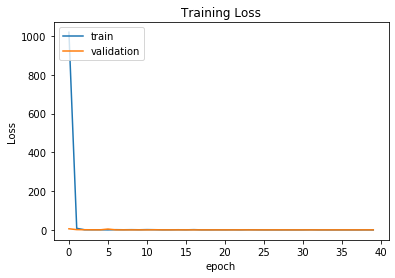

In [135]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

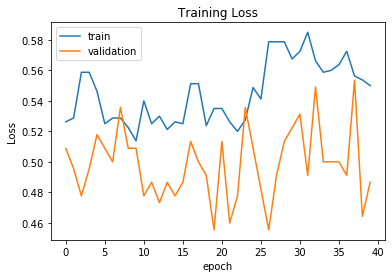

In [136]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()